In [86]:
import cv2
import pytesseract 
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.animation
import numpy as np
import pandas as pd
import seaborn as sns
import math
from IPython.display import HTML
from scipy import stats
from scipy.signal import butter, lfilter

In [87]:
data = pd.read_excel('DigitalData.xlsx', sheet_name = 'CPET')
patient_info = pd.read_excel('DigitalData.xlsx', sheet_name = 'Patient')
patient_info['BMI']=patient_info['weight-kg']/(patient_info['height-cm']/100)**2
data_filt=data[['PatientId','Time','TestLevel','HR','VO2','VO2/kg','VCO2','VE','VEO2','VECO2','FE02','FECO2','RER','RR','METS','TMSPD','TMELV','Source','TypeUser']]

In [88]:
minutes = []
for i in data_filt.Time:
    minutes.append(i.second/60+i.minute)
data_filt['minutes']=np.array(minutes)

C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [89]:
patients_complete_only = data_filt.dropna().copy()
patients_complete_only['VO2/HR']=patients_complete_only.VO2/patients_complete_only.HR*1000
final_info = patients_complete_only.join(patient_info.set_index('patientid'), on="PatientId")
final_info['ID'] = final_info.index

# Creating a 30 second average dataset

In [165]:
def round_to_30s(row):
    base = np.floor(row.minutes)
    med = base +0.5
    sup = np.round(row.minutes)
    if row.minutes <= med:
        return med
    else:
        return sup
    pass

In [166]:
final_info.head(5)
patient_times = final_info.groupby(['PatientId'])['minutes'].max().reset_index()
patient_times['max_time'] = patient_times.apply(round_to_30s, axis=1)
patient_times.head()

PatientId    minutes  max_time
0          4  11.466667      11.5
1          5  12.750000      13.0
2          6  13.983333      14.0
3          7  15.750000      16.0
4          8  13.700000      14.0

In [167]:
df_info_avg = pd.DataFrame(columns = ['PatientId','minutes'])
for i in patient_times.PatientId:
    patient_time_min = np.arange(0.5,patient_times.loc[patient_times.PatientId==i]['max_time'].values[0],.5)
    #print(patient_time_min)
    patient_ids=np.ones(patient_time_min.shape)*i
    #print(patient_ids)
    tempdf = pd.DataFrame({'PatientId': patient_ids, 'minutes': patient_time_min })
    #print(tempdf)
    df_info_avg=df_info_avg.append(tempdf, ignore_index=True)
    pass
df_info_avg.head()

PatientId  minutes
0        4.0      0.5
1        4.0      1.0
2        4.0      1.5
3        4.0      2.0
4        4.0      2.5

In [168]:
def round_to_mean(column, row):
    return np.mean(final_info.loc[(final_info.PatientId == row.PatientId) & 
                   (final_info.minutes >= (row.minutes-0.5)) &
                   (final_info.minutes < (row.minutes))][column].values)

In [169]:
def place_labels(column, row):
    return final_info.loc[(final_info.PatientId == row.PatientId) & 
                   (final_info.minutes >= (row.minutes-0.5)) &
                   (final_info.minutes < (row.minutes))][column].values[0]

In [170]:
#data_filt=data[['PatientId','Time','TestLevel','HR','VO2','VO2/kg','VCO2','VE','VEO2','VECO2','FE02','FECO2','RER','RR','METS','TMSPD','TMELV','Source','TypeUser']]
#df_info_avg['HR']=np.round(df_info_avg.apply(round_to_mean,axis=1),0)
df_info_avg['HR']=np.round(df_info_avg.apply(lambda x: round_to_mean('HR',x),axis=1),2)
df_info_avg['VO2']=df_info_avg.apply(lambda x: round_to_mean('VO2',x),axis=1)
df_info_avg['VO2/kg']=df_info_avg.apply(lambda x: round_to_mean('VO2/kg',x),axis=1)
df_info_avg['VCO2']=df_info_avg.apply(lambda x: round_to_mean('VCO2',x),axis=1)
df_info_avg['VE']=df_info_avg.apply(lambda x: round_to_mean('VE',x),axis=1)
df_info_avg['VEO2']=df_info_avg.apply(lambda x: round_to_mean('VEO2',x),axis=1)
df_info_avg['VECO2']=df_info_avg.apply(lambda x: round_to_mean('VECO2',x),axis=1)
df_info_avg['FE02']=df_info_avg.apply(lambda x: round_to_mean('FE02',x),axis=1)
df_info_avg['FECO2']=df_info_avg.apply(lambda x: round_to_mean('FECO2',x),axis=1)
df_info_avg['RER']=df_info_avg.apply(lambda x: round_to_mean('RER',x),axis=1)
df_info_avg['RR']=df_info_avg.apply(lambda x: round_to_mean('RR',x),axis=1)
df_info_avg['METS']=df_info_avg.apply(lambda x: round_to_mean('METS',x),axis=1)
df_info_avg['TMSPD']=df_info_avg.apply(lambda x: round_to_mean('TMSPD',x),axis=1)
df_info_avg['TMELV']=df_info_avg.apply(lambda x: round_to_mean('TMELV',x),axis=1)
df_info_avg['VO2/HR']=df_info_avg.apply(lambda x: round_to_mean('VO2/HR',x),axis=1)
df_info_avg['BMI']=df_info_avg.apply(lambda x: round_to_mean('BMI',x),axis=1)
df_info_avg['TypeUser']=df_info_avg.apply(lambda x: place_labels('TypeUser',x),axis=1)
df_info_avg['TestLevel']=df_info_avg.apply(lambda x: place_labels('TestLevel',x),axis=1)
df_info_avg.head()

PatientId  minutes     HR   VO2  VO2/kg   VCO2      VE  VEO2  VECO2  \
0        4.0      0.5  108.0  0.48    4.50  0.410  14.900  31.0   36.0   
1        4.0      1.0  107.0  0.56    5.70  0.540  19.705  32.0   36.5   
2        4.0      1.5  109.5  0.46    4.30  0.465  18.255  39.5   39.0   
3        4.0      2.0  112.5  0.48    4.50  0.515  20.685  42.5   40.0   
4        4.0      2.5  115.5  0.34    3.15  0.375  16.180  48.0   43.0   

     FE02  FECO2   RER    RR  METS  TMSPD  TMELV    VO2/HR  BMI TypeUser  \
0  17.220  3.350  0.87  11.0  1.30    0.0    0.0  4.444444  NaN  Unknown   
1  17.325  3.325  0.89  11.5  1.65    0.0    0.0  5.247706  NaN  Unknown   
2  17.920  3.110  1.00  11.0  1.25    0.0    0.0  4.199199  NaN  Unknown   
3  18.075  3.040  1.06  12.5  1.30    0.0    0.0  4.269912  NaN  Unknown   
4  18.380  2.820  1.11  11.5  0.90    0.0    0.0  2.941154  NaN  Unknown   

  TestLevel  
0    Warmup  
1    Warmup  
2    Warmup  
3    Warmup  
4    Warmup

In [171]:
df_info_avg['VE/VCO2']=df_info_avg['VE']/df_info_avg['VCO2']
df_info_avg['VE/VO2']=df_info_avg['VE']/df_info_avg['VO2']
df_info_avg['O2']=df_info_avg.VO2/df_info_avg.HR*1000

In [172]:
gfg_csv_data = df_info_avg.to_csv('data_averaged.csv', index = True) 

In [176]:
def get_corrs_previous(row, df, column1, column2, corr_size=3):
    data=df.loc[(df.PatientId == row.PatientId) & (df.minutes <= row.minutes)][[column1,column2]].values[-corr_size:]
    if data[:,0].shape[0] == 1:
        return 0
    x_mean=np.mean(data[:,0])
    y_mean=np.mean(data[:,1])
    x_norm=data[:,0]-x_mean
    y_norm=data[:,1]-y_mean
    res = np.sum(x_norm*y_norm)/np.sqrt(np.sum(x_norm**2)*np.sum(y_norm**2))
    return np.sum(x_norm*y_norm)/np.sqrt(np.sum(x_norm**2)*np.sum(y_norm**2))
    return np.corrcoef(data[:,0], data[:,1])

In [187]:
df_info_avg['CorrVO2HR']=np.round(df_info_avg.apply(lambda x: get_corrs_previous(x,df_info_avg,'VO2','HR',5),axis=1),2)
df_info_avg['CorrVeVCO2']=np.round(df_info_avg.apply(lambda x: get_corrs_previous(x,df_info_avg,'VE','VECO2',5),axis=1),2)
df_info_avg['CorrVCO2VO2']=np.round(df_info_avg.apply(lambda x: get_corrs_previous(x,df_info_avg,'VCO2','VO2',5),axis=1),2)

C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [188]:
df_info_avg[['PatientId','minutes','CorrVO2HR','CorrVeVCO2','CorrVCO2VO2']].head()

PatientId  minutes  CorrVO2HR  CorrVeVCO2  CorrVCO2VO2
0        4.0      0.5       0.00        0.00         0.00
1        4.0      1.0      -1.00        1.00         1.00
2        4.0      1.5      -0.90        0.37         0.81
3        4.0      2.0      -0.58        0.65         0.65
4        4.0      2.5      -0.87        0.02         0.83

In [189]:
df_info_avg[['PatientId','minutes','CorrVO2HR','CorrVeVCO2','CorrVCO2VO2']].to_csv('data_corr_averaged.csv', index = True) 

In [190]:
final_info['CorrVO2HR']=final_info.apply(lambda x: get_corrs_previous(x,final_info,'VO2','HR',5),axis=1)
final_info['CorrVeVCO2']=final_info.apply(lambda x: get_corrs_previous(x,final_info,'VE','VECO2',5),axis=1)
final_info['CorrVCO2VO2']=final_info.apply(lambda x: get_corrs_previous(x,final_info,'VCO2','VO2',5),axis=1)

C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [191]:
final_info[['PatientId','minutes','CorrVO2HR','CorrVeVCO2','CorrVCO2VO2']].to_csv('data_corr_raw.csv', index = True) 

## End of Correlations

In [ ]:
def get_corrs_previous(row, df, column1, column2, corr_size=3):
    data=df.loc[(df.PatientId == row.PatientId) & (df.minutes <= row.minutes)][[column1,column2]].values[-corr_size:]
    return np.corrcoef(data[:,0], data[:,1])[0]

## Correlations Dataset

In [117]:
def get_corrs_previous(row, df, column1, column2, corr_size=3):
    data=df.loc[(df.PatientId == row.PatientId) & (df.minutes <= row.minutes)][[column1,column2]].values[-corr_size:]
    return np.correlate(data[:,0], data[:,1])[0]

In [33]:
df_info_avg.loc[(df_info_avg.PatientId == 4) & (df_info_avg.minutes <= 6)][['VO2','HR']]

VO2     HR
0   0.480  108.0
1   0.560  107.0
2   0.460  110.0
3   0.480  112.0
4   0.340  116.0
5   0.435  116.0
6   1.360  116.0
7   1.460  118.0
8   1.460  118.0
9   1.795  119.0
10  1.870  122.0
11  2.020  126.0

In [44]:
data = df_info_avg.loc[(df_info_avg.PatientId == 4) & (df_info_avg.minutes <= 6)][['VO2','HR']].values[-5:]
np.correlate(data[:,0], data[:,1])[0]

1040.825

In [46]:
data

array([[  1.46 , 118.   ],
       [  1.46 , 118.   ],
       [  1.795, 119.   ],
       [  1.87 , 122.   ],
       [  2.02 , 126.   ]])

## Once the 30s average dataset is done, now the other elements are calculated

### Let's begin with cardiac deficiency

In [106]:
def get_cardiac_limitation(df):
    df['CardiacDef'] = -1
    for pid in df.PatientId.drop_duplicates().values:
        df_pid = df.loc[df.PatientId==pid]
        if df_pid.O2.values[0] == np.inf:
            continue
        min_mid = range(int(np.round(df_pid.shape[0]/4)),int(np.round(df_pid.shape[0]/2)))
        max_mid = range(int(np.round(df_pid.shape[0]/2)),int(np.round(3*df_pid.shape[0]/4)))
        df_min = df_pid.iloc[min_mid,:]
        df_max = df_pid.iloc[max_mid,:]
        x_df_min = df_min.minutes.values
        y_df_min = df_min.O2.values
        x_df_max = df_max.minutes.values
        y_df_max = df_max.O2.values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_min, y_df_min)
        atan_inf = np.arctan(slope)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_max, y_df_max)
        atan_sup = np.arctan(slope)
        df.loc[(df.PatientId == pid),'CardiacDef']=np.abs(atan_inf-atan_sup)/(np.pi/2)
        pass
    return df
    pass

In [104]:
df_info_avg = get_cardiac_limitation(df_info_avg)

### Now, let's do pulmonary deficiency

In [ ]:
final_info['CardiacDef'] = -1
for pid in final_info.PatientId.drop_duplicates().values:
    df_pid = final_info.loc[final_info.PatientId==pid]
    if df_pid.O2.values[0] == np.inf:
        continue
    min_mid = range(int(np.round(df_pid.shape[0]/4)),int(np.round(df_pid.shape[0]/2)))
    max_mid = range(int(np.round(df_pid.shape[0]/2)),int(np.round(3*df_pid.shape[0]/4)))
    df_min = df_pid.iloc[min_mid,:]
    df_max = df_pid.iloc[max_mid,:]
    x_df_min = df_min.minutes.values
    y_df_min = df_min.O2.values
    x_df_max = df_max.minutes.values
    y_df_max = df_max.O2.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_min, y_df_min)
    atan_inf = np.arctan(slope)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_max, y_df_max)
    atan_sup = np.arctan(slope)
    final_info.loc[(final_info.PatientId == pid),'CardiacDef']=np.abs(atan_inf-atan_sup)/(np.pi/2)
    pass

In [103]:
df_info_avg.head()

PatientId  minutes     HR   VO2  VO2/kg   VCO2      VE  VEO2  VECO2  \
0        4.0      0.5  108.0  0.48    4.50  0.410  14.900  31.0   36.0   
1        4.0      1.0  107.0  0.56    5.70  0.540  19.705  32.0   36.5   
2        4.0      1.5  110.0  0.46    4.30  0.465  18.255  39.5   39.0   
3        4.0      2.0  112.0  0.48    4.50  0.515  20.685  42.5   40.0   
4        4.0      2.5  116.0  0.34    3.15  0.375  16.180  48.0   43.0   

     FE02  ...  TMSPD  TMELV    VO2/HR  BMI  TypeUser  TestLevel    VE/VCO2  \
0  17.220  ...    0.0    0.0  4.444444  NaN   Unknown     Warmup  36.341463   
1  17.325  ...    0.0    0.0  5.247706  NaN   Unknown     Warmup  36.490741   
2  17.920  ...    0.0    0.0  4.199199  NaN   Unknown     Warmup  39.258065   
3  18.075  ...    0.0    0.0  4.269912  NaN   Unknown     Warmup  40.165049   
4  18.380  ...    0.0    0.0  2.941154  NaN   Unknown     Warmup  43.146667   

      VE/VO2        O2 CardiacDef  
0  31.041667  4.444444   0.414325  
1  35.187500  5.233645   0.414325  
2  39.684783  4.181818   0.414325  
3  43.093750  4.285714   0.414325  
4  47.588235  2.931034   0.414325  

[5 rows x 24 columns]

In [91]:
def plot_2_axis(df,title, col1, col2=None):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (min)')
    ax1.set_ylabel(col1, color=color)
    ax1.scatter(df.minutes, df[col1], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    if col2 is None:
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.title(title)
        plt.show()
        return
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(col2, color=color)  # we already handled the x-label with ax1
    ax2.scatter(df.minutes, df[col2], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()
    pass

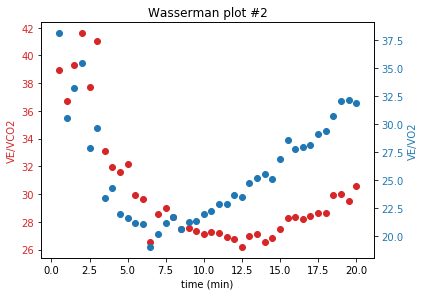

In [92]:
plot_2_axis(df_info_avg.loc[df_info_avg.PatientId==14],'Wasserman plot #2', 'VE/VCO2', 'VE/VO2')

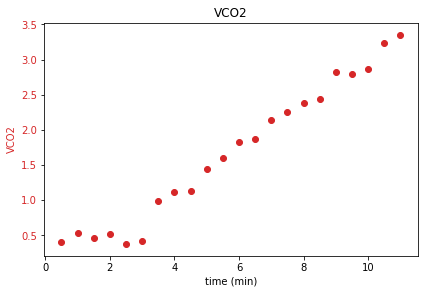

In [93]:
plot_2_axis(df_info_avg.loc[df_info_avg.PatientId==4],'VCO2', 'VCO2')

In [70]:
final_info.loc[final_info.PatientId==6][['minutes','TypeUser']]

minutes TypeUser
232   0.300000  Unknown
233   0.516667  Unknown
234   0.766667  Unknown
235   1.083333  Unknown
236   1.250000  Unknown
237   1.550000  Unknown
238   1.783333  Unknown
239   2.050000  Unknown
240   2.300000  Unknown
241   2.500000  Unknown
242   2.800000  Unknown
243   3.016667  Unknown
244   3.300000  Unknown
245   3.533333  Unknown
246   3.800000  Unknown
247   4.016667  Unknown
248   4.266667  Unknown
249   4.516667  Unknown
250   4.800000  Unknown
251   5.016667  Unknown
252   5.250000  Unknown
253   5.516667  Unknown
254   5.766667  Unknown
255   6.000000  Unknown
256   6.283333  Unknown
257   6.516667  Unknown
258   6.750000  Unknown
259   7.016667  Unknown
260   7.250000  Unknown
261   7.516667  Unknown
262   7.766667  Unknown
263   8.033333  Unknown
264   8.283333  Unknown
265   8.500000  Unknown
266   8.766667  Unknown
267   9.000000  Unknown
268   9.266667  Unknown
269   9.516667  Unknown
270   9.783333  Unknown
271  10.066667  Unknown
272  10.266667  Unknown
273  10.516667  Unknown
274  10.750000  Unknown
275  11.000000  Unknown
276  11.516667  Unknown
277  11.533333  Unknown
278  11.750000  Unknown
279  12.000000  Unknown
280  12.283333  Unknown
281  12.500000  Unknown
282  12.750000  Unknown
283  13.016667  Unknown
284  13.250000  Unknown
285  13.500000  Unknown
286  13.766667  Unknown
287  13.983333  Unknown

In [49]:

data_filt=data[['PatientId','Time','TestLevel','HR','VO2','VO2/kg','VCO2','VE','VEO2','VECO2','FE02','FECO2','RER','RR','METS','TMSPD','TMELV','Source','TypeUser']]
final_info[['PatientId','HR','minutes']]

PatientId     HR    minutes
135           4  108.0   0.266667
136           4  109.0   0.516667
137           4  105.0   0.783333
138           4  108.0   1.050000
139           4  111.0   1.250000
...         ...    ...        ...
1246         21  171.0  13.516667
1247         21  171.0  13.766667
1248         21  173.0  14.000000
1249         21  176.0  14.266667
1250         21  173.5  14.516667

[1116 rows x 3 columns]

In [53]:
final_info[['Source','TypeUser']].head()

Source TypeUser
135  deidentified vo2 printouts.pdf  Unknown
136  deidentified vo2 printouts.pdf  Unknown
137  deidentified vo2 printouts.pdf  Unknown
138  deidentified vo2 printouts.pdf  Unknown
139  deidentified vo2 printouts.pdf  Unknown

In [54]:
final_info

PatientId      Time TestLevel     HR       VO2     VO2/kg      VCO2  \
135           4  00:00:16    Warmup  108.0  0.480000   4.500000  0.410000   
136           4  00:00:31    Warmup  109.0  0.490000   5.500000  0.520000   
137           4  00:00:47    Warmup  105.0  0.630000   5.900000  0.560000   
138           4  00:01:03    Warmup  108.0  0.440000   4.100000  0.430000   
139           4  00:01:15    Warmup  111.0  0.480000   4.500000  0.500000   
...         ...       ...       ...    ...       ...        ...       ...   
1246         21  00:13:31  Exercise  171.0  1.311591  21.421682  1.576645   
1247         21  00:13:46  Exercise  171.0  1.513444  24.718456  1.795456   
1248         21  00:14:00  Exercise  173.0  1.435776  23.449938  1.790068   
1249         21  00:14:16  Exercise  176.0  1.295434  21.157795  1.614645   
1250         21  00:14:31  Recovery  173.5  1.127898  18.421505  1.346262   

             VE       VEO2      VECO2  ...  height-cm  weight-kg  Doctor  \
135   14.900000  31.000000  36.000000  ...        NaN        NaN     NaN   
136   18.940000  32.000000  37.000000  ...        NaN        NaN     NaN   
137   20.470000  32.000000  36.000000  ...        NaN        NaN     NaN   
138   16.710000  38.000000  39.000000  ...        NaN        NaN     NaN   
139   19.800000  41.000000  39.000000  ...        NaN        NaN     NaN   
...         ...        ...        ...  ...        ...        ...     ...   
1246  50.537750  38.531635  32.053986  ...    151.765   61.22727   Kraus   
1247  58.259583  38.494717  32.448357  ...    151.765   61.22727   Kraus   
1248  59.673870  41.562115  33.336098  ...    151.765   61.22727   Kraus   
1249  53.861698  41.578110  33.358223  ...    151.765   61.22727   Kraus   
1250  41.796143  37.056652  31.046066  ...    151.765   61.22727   Kraus   

      BaseO2  BaseCO2  year_of_test                           Place  \
135      NaN      NaN           NaN                             NaN   
136      NaN      NaN           NaN                             NaN   
137      NaN      NaN           NaN                             NaN   
138      NaN      NaN           NaN                             NaN   
139      NaN      NaN           NaN                             NaN   
...      ...      ...           ...                             ...   
1246  0.2094   0.0004        2012.0  Duke University Medical Center   
1247  0.2094   0.0004        2012.0  Duke University Medical Center   
1248  0.2094   0.0004        2012.0  Duke University Medical Center   
1249  0.2094   0.0004        2012.0  Duke University Medical Center   
1250  0.2094   0.0004        2012.0  Duke University Medical Center   

                                    Place2        BMI    ID  
135                                    NaN        NaN   135  
136                                    NaN        NaN   136  
137                                    NaN        NaN   137  
138                                    NaN        NaN   138  
139                                    NaN        NaN   139  
...                                    ...        ...   ...  
1246  CFL Human Performance Lab - Parvo #1  26.582856  1246  
1247  CFL Human Performance Lab - Parvo #1  26.582856  1247  
1248  CFL Human Performance Lab - Parvo #1  26.582856  1248  
1249  CFL Human Performance Lab - Parvo #1  26.582856  1249  
1250  CFL Human Performance Lab - Parvo #1  26.582856  1250  

[1116 rows x 33 columns]

In [42]:
np.arange(0.5,11.5,.5)

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ])

In [35]:
def round_to_30s(row):
    base = np.floor(row.minutes)
    med = base +0.5
    sup = np.round(row.minutes)
    if row.minutes <= med:
        return med
    else:
        return sup
    pass

In [21]:
np.floor(15.25)

15.0

# Calculating Pulmonary Limitation based on the Hardy Paper

In [105]:
final_info['VE/VCO2']=final_info['VE']/final_info['VCO2']
final_info['MVV_real'] = final_info.groupby(['PatientId'])['FE02'].transform(max)
for pid in final_info.PatientId.drop_duplicates().values:
    df_pid = final_info.loc[final_info.PatientId==pid]
    first_time = np.min(df_pid.minutes.values)
    base_value = df_pid.loc[(df_pid.minutes == first_time)].FE02.values*40
    final_info.loc[(final_info.PatientId == pid) ,'MVV_real']=base_value
    pass

In [6]:
final_info['PulmonaryLimitation']=final_info['VE']/final_info['MVV_real']
final_info['PulmonaryLimitationMax'] = final_info.groupby(['PatientId'])['PulmonaryLimitation'].transform(max)

# Getting the O2

In [7]:
final_info['O2']=final_info.VO2/final_info.HR*1000
final_info.head()

PatientId      Time TestLevel     HR   VO2  VO2/kg  VCO2     VE  VEO2  \
135          4  00:00:16    Warmup  108.0  0.48     4.5  0.41  14.90  31.0   
136          4  00:00:31    Warmup  109.0  0.49     5.5  0.52  18.94  32.0   
137          4  00:00:47    Warmup  105.0  0.63     5.9  0.56  20.47  32.0   
138          4  00:01:03    Warmup  108.0  0.44     4.1  0.43  16.71  38.0   
139          4  00:01:15    Warmup  111.0  0.48     4.5  0.50  19.80  41.0   

     VECO2  ...  year_of_test  Place  Place2  BMI   ID    VE/VCO2  MVV_real  \
135   36.0  ...           NaN    NaN     NaN  NaN  135  36.341463     688.8   
136   37.0  ...           NaN    NaN     NaN  NaN  136  36.423077     688.8   
137   36.0  ...           NaN    NaN     NaN  NaN  137  36.553571     688.8   
138   39.0  ...           NaN    NaN     NaN  NaN  138  38.860465     688.8   
139   39.0  ...           NaN    NaN     NaN  NaN  139  39.600000     688.8   

    PulmonaryLimitation PulmonaryLimitationMax        O2  
135            0.021632               0.163429  4.444444  
136            0.027497               0.163429  4.495413  
137            0.029718               0.163429  6.000000  
138            0.024260               0.163429  4.074074  
139            0.028746               0.163429  4.324324  

[5 rows x 38 columns]

# Getting the Cardiac Limitation

In [8]:
final_info['CardiacDef'] = -1
for pid in final_info.PatientId.drop_duplicates().values:
    df_pid = final_info.loc[final_info.PatientId==pid]
    if df_pid.O2.values[0] == np.inf:
        continue
    min_mid = range(int(np.round(df_pid.shape[0]/4)),int(np.round(df_pid.shape[0]/2)))
    max_mid = range(int(np.round(df_pid.shape[0]/2)),int(np.round(3*df_pid.shape[0]/4)))
    df_min = df_pid.iloc[min_mid,:]
    df_max = df_pid.iloc[max_mid,:]
    x_df_min = df_min.minutes.values
    y_df_min = df_min.O2.values
    x_df_max = df_max.minutes.values
    y_df_max = df_max.O2.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_min, y_df_min)
    atan_inf = np.arctan(slope)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_max, y_df_max)
    atan_sup = np.arctan(slope)
    final_info.loc[(final_info.PatientId == pid),'CardiacDef']=np.abs(atan_inf-atan_sup)/(np.pi/2)
    pass

# Getting the Skeletal deficienciy

In [9]:
plot_it = False
for pid in final_info.PatientId.drop_duplicates().values:
    df_pid = final_info.loc[(final_info.PatientId==pid) #& (final_info.TestLevel == 'Exercise')  
                            & (final_info.minutes > 0)]
    df_pid_slope = df_pid.copy()
    slope_index = range(int(np.round(df_pid.shape[0]/3.25)),int(np.round(df_pid.shape[0]/2)))
    df_pid_slope = df_pid_slope.iloc[slope_index,:]
    x_df = df_pid.minutes.values
    y_df = df_pid.VCO2.values
    x_df_slope = df_pid_slope.minutes.values
    y_df_slope = df_pid_slope.VCO2.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_slope, y_df_slope)
    times = df_pid.minutes
    y_est = times * slope + intercept
    y_error = df_pid.VCO2.values - y_est
    indexes = np.where(y_error>0.5)
    at_time = x_df[-1]
    if(indexes[0].size >0):
        at_time = x_df[indexes[0][0]]
        pass
    final_info.loc[(final_info.PatientId == pid),'SkeletalLimit']=np.abs(x_df[-1]-at_time)/x_df[-1]
    if plot_it is True:
        print(indexes[0])
        print(x_df[indexes[0]])
        print(at_time)
        print(x_df[-1])
        print(np.abs(x_df[-1]-at_time)/x_df[-1])
        #print(y_est[indexes])
        #print(x_df[indexes])
        faux_y = slope * df_pid.minutes.values + intercept
        #plt.annotate('Turning Point', xy=(y_error[]))
        plt.title("Plotting for {}: {}".format(pid, df_pid.TypeUser.values[0]))
        plt.plot(df_pid.minutes.values, df_pid.VCO2.values)
        plt.plot(df_pid.minutes.values, faux_y)
        plt.xlabel('time(min)')  
        plt.ylabel('VO2') 
        plt.show()
    pass

In [10]:
type_patient_dict = {"Unknown": None, "YoungAthlete": "young athlete", "HealthyNonAthlete": "Healthy non athlete"}
def radar_plot_limitations(patient_id, pulmonary, cardiac, skeletal, patient_type="Unknown"):
    categories = ['Pulmonary limitation', 'Cardiac limitation', 'Skeletal limitation']
    patient_type_value = type_patient_dict[patient_type]
    N = len(categories)
    values = [pulmonary,cardiac,skeletal]
    values += values[:1]
    angles = [n/ float(N)*2*np.pi for n in range(N)]
    angles += angles[:1]
    #plt.title("Radar plot limitation for patient {}".format(patient_id))
    #plt.title("REEE")
    if patient_type_value is not None:
        print('Patient {} is a {}'.format(i,patient_type_value))
    plt.polar(angles, values)
    plt.xticks(angles[:-1], categories)
    plt.ylim(0,1)
    plt.show()

In [11]:
df_patient_resume = final_info[['PatientId','SkeletalLimit','CardiacDef','PulmonaryLimitationMax','TypeUser']].drop_duplicates()
df_patient_resume = df_patient_resume.loc[df_patient_resume.CardiacDef >= 0]
df_patient_resume

PatientId  SkeletalLimit  CardiacDef  PulmonaryLimitationMax  \
135           4       0.976744    0.079635                0.163429   
181           5       0.000000    0.057481                0.086511   
232           6       0.000000    0.360773                0.154335   
288           7       0.253968    0.013319                0.059895   
351           8       0.124088    0.226342                0.082082   
406           9       0.247986    0.011202                0.140867   
481          10       0.235242    0.203113                0.224371   
556          11       0.415347    0.089151                0.158245   
611          12       0.350450    0.071401                0.227396   
685          13       0.238498    0.072878                0.116760   
756          14       0.000000    0.175078                0.112454   
837          15       0.000000    0.024154                0.041170   
951          17       0.250892    0.221251                0.327619   
1007         18       0.301887    0.180676                0.272386   
1060         19       0.000000    0.327443                0.164589   
1139         20       0.979038    0.673881                0.105865   
1193         21       0.276693    0.409457                0.077425   

               TypeUser  
135             Unknown  
181             Unknown  
232             Unknown  
288             Unknown  
351             Unknown  
406        YoungAthlete  
481        YoungAthlete  
556        YoungAthlete  
611        YoungAthlete  
685             Unknown  
756             Unknown  
837             Unknown  
951        YoungAthlete  
1007       YoungAthlete  
1060  HealthyNonAthlete  
1139  HealthyNonAthlete  
1193  HealthyNonAthlete

Radar plot for patient 4


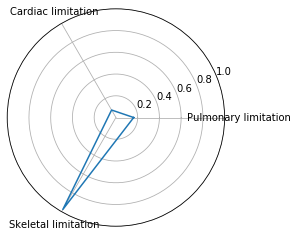

Radar plot for patient 5


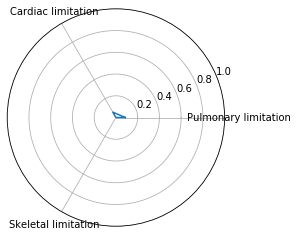

Radar plot for patient 6


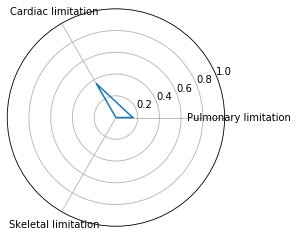

Radar plot for patient 7


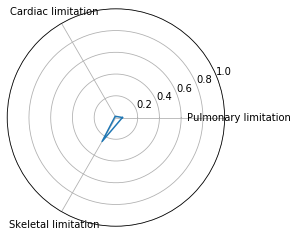

Radar plot for patient 8


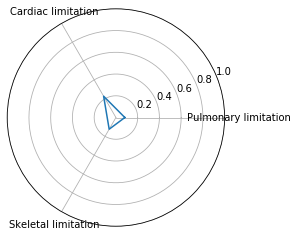

Radar plot for patient 9
Patient 9 is a young athlete


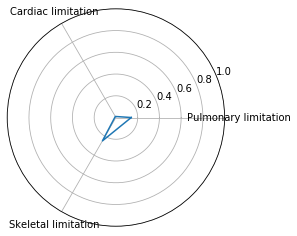

Radar plot for patient 10
Patient 10 is a young athlete


Radar plot for patient 11
Patient 11 is a young athlete


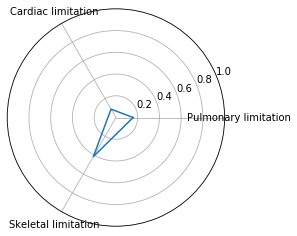

Radar plot for patient 12
Patient 12 is a young athlete


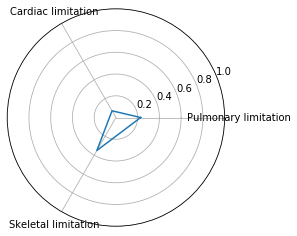

Radar plot for patient 13


Radar plot for patient 14


Radar plot for patient 15


Radar plot for patient 17
Patient 17 is a young athlete


Radar plot for patient 18
Patient 18 is a young athlete


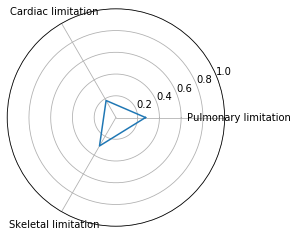

Radar plot for patient 19
Patient 19 is a Healthy non athlete


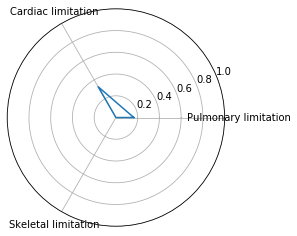

Radar plot for patient 20
Patient 20 is a Healthy non athlete


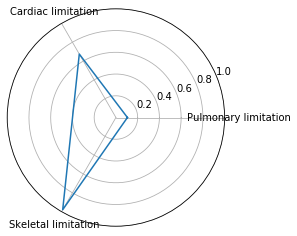

Radar plot for patient 21
Patient 21 is a Healthy non athlete


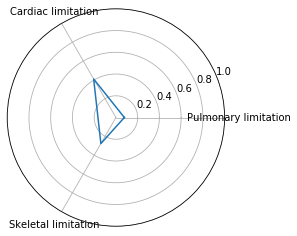

In [12]:
for i in df_patient_resume.PatientId.values:
    resume = df_patient_resume.loc[df_patient_resume.PatientId==i]
    print('Radar plot for patient {}'.format(i))
    radar_plot_limitations(resume.PatientId.values[0], resume.PulmonaryLimitationMax.values[0],
                           resume.CardiacDef.values[0], resume.SkeletalLimit.values[0],resume.TypeUser.values[0])
    pass